Map area for this project is washingdon DC. The link is listed here: 
<a class="link" href="https://s3.amazonaws.com/mapzen.odes/ex_tN4Y7kB1ExvW58PaexkvgZBMpmdiq.osm.bz2" data-format="OSM XML">OSM XML <span class="size">19MB</span></a>

Our objective is: Audit, clean the OSM dataset, convert from XML to JSON format, insert to MongoDB and analyze insight within the data.

# 1.Data audition

In [7]:
import os
import xml.etree.cElementTree as ET
from collections import defaultdict
import pprint
import re
import codecs
import json
import string
import codecs
from pymongo import MongoClient

Read through the dataset with path.join function and count the number of unique entry types to get an overall feature of DC.osm with count_tag function.

In [8]:
filename = "DC.osm" 
path = "/Users/fengxinlin/Downloads" 
DC_OSM = os.path.join(path, filename)

In [9]:
def count_tags(filename):
        tags = {}
        for event, elem in ET.iterparse(filename):
            if elem.tag in tags: 
                tags[elem.tag] += 1
            else:
                tags[elem.tag] = 1
        return tags
DC_tags = count_tags(DC_OSM)
pprint.pprint(DC_tags)

{'bounds': 1,
 'member': 11547,
 'nd': 1748435,
 'node': 1411550,
 'osm': 1,
 'relation': 2534,
 'tag': 1272991,
 'way': 172612}


The following function key_type and process_map. I wish to check the "k" value for each entry.
For the function 'key_type', we have a count of each of three tag categories in a dictionary: "lower", for tags that contain only lowercase letters and are valid, "lower_colon", for otherwise valid tags with a colon in their names, "problemchars", for tags with problematic characters, and in the next block, is trying to find out how many unique users have contributed to this OSM file.

In [10]:
lower = re.compile(r'^([a-z])*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
#any non-number, non-letter symbol:
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
    

def key_type(element, keys):
    if element.tag == "tag":
        for tag in element.iter('tag'):
            k = tag.get('k')
            if lower.search(k):
                keys['lower'] += 1
            elif lower_colon.search(k):
                keys['lower_colon'] += 1
            elif problemchars.search(k):
                keys['problemchars'] += 1
            else:
                keys['other'] += 1
    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

map_keys = process_map(DC_OSM)
pprint.pprint(map_keys)

{'lower': 445855, 'lower_colon': 793061, 'other': 34073, 'problemchars': 2}


In [11]:
def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        for e in element:
            if 'uid' in e.attrib:
                users.add(e.attrib['uid'])
    return users
users = process_map(DC_OSM)
len(users)

1428

# 2.Problem
## 2.1 Street rename
Here is a problem encountered in this dataset come from the street name abbreviation inconsistency. I build the regex matching the last element in the string, where usually the street type is based.  

In [12]:
street_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
expected = ["Avenue", "Boulevard", "Commons", "Court", "Drive", "Lane", "Parkway", "Place", "Road", "Square", "Street",
            "Trail"]
mapping = {'Ave': 'Avenue', 'Blvd' : 'Boulevard', 'Dr' : 'Drive', 'Ln' : 'Lane', 'Pkwy' : 'Parkway', 'Rd' : 'Road', 
           'Rd.' : 'Road', 'St' : 'Street', 'street' :"Street", 'Ct' : "Court", 'Cir': "Circle", 'Cr' : "Court", 
           'ave' : 'Avenue', 'Hwg' : 'Highway', 'Hwy' : 'Highway', 'Sq' : "Square"}

The "audit_street_type" function search the input string for its regex. If it matches and it is not within the "expected" list, add the match as a key and add the string to the set.

The "is_street_name" function runs when k="addre:street" and looks at the attribute k.

The "audit" function will return a list that match previous two functions. After that, we would have a pretty printout which contains the output of the audit. With a list of all the abbreviated street types we can understand and fill-up "mapping" as a preparation to convert these street and road name into proper form.

In [13]:
def audit_street_type(street_types, street_name):
    m = street_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

            
def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types

DC_street_types = audit(DC_OSM)
            

Print it out to have a brief look at the unclean street data set:

In [14]:
pprint.pprint(dict(DC_street_types))

{'1': set(['1']),
 '100': set(['L St NW #100']),
 '2': set(['Piney Branch Road Northwest, Suite #2',
           'South Glebe Road, Bldg. 2']),
 '850': set(['Connecticut Avenue Northwest Suite 850']),
 'Alley': set(['Blagden Alley']),
 'Ave': set(['Campbell Ave', 'South Potomac Ave']),
 'BN': set(['North Capitol Street BN']),
 'Blvd': set(['Clarendon Blvd', 'Wilson Blvd']),
 'Circle': set(['Westmoreland Circle']),
 'Dr': set(['N Fort Myer Dr', 'Wesmond Dr']),
 'Eads': set(['South Eads']),
 'East': set(['Campus Lane East']),
 'Expressway': set(['12th Street Expressway']),
 'Highway': set(['Jefferson Davis Highway',
                 'Lee Highway',
                 'North Lee Highway',
                 'South Jefferson Davis Highway']),
 'Hill': set(['Capitol Hill']),
 'Hwy': set(['Jefferson Davis Hwy']),
 'Ln': set(['Evans Ln']),
 'N.W.': set(['31st Street N.W.']),
 'NE': set(['12th Street NE',
            '16th Street NE',
            '17th Street NE',
            '1st St NE',
          

The function "update_name" is the last step of street rename processing, which takes the old name and update them to the format I want.

In [15]:
def update_name(name, mapping, regex):
    m = regex.search(name)
    if m:
        street_type = m.group()
        if street_type in mapping:
            name = re.sub(regex, mapping[street_type], name)

    return name


for street_type, ways in DC_street_types.iteritems():
    for name in ways:
        new_name = update_name(name, mapping, street_re)
        print name, "=>", new_name

Penn Street Northeast => Penn Street Northeast
Oglethorpe Street Northeast => Oglethorpe Street Northeast
Belair Place Northeast => Belair Place Northeast
Blaine Street Northeast => Blaine Street Northeast
Terrace Court Northeast => Terrace Court Northeast
Walnut Street Northeast => Walnut Street Northeast
Elliott Street Northeast => Elliott Street Northeast
Girard Place Northeast => Girard Place Northeast
Queen Street Northeast => Queen Street Northeast
New York Avenue Northeast => New York Avenue Northeast
Bates Road Northeast => Bates Road Northeast
Ava Circle Northeast => Ava Circle Northeast
Gallatin Place Northeast => Gallatin Place Northeast
Lexington Place Northeast => Lexington Place Northeast
Central Place Northeast => Central Place Northeast
18th Place Northeast => 18th Place Northeast
Park Avenue Northeast => Park Avenue Northeast
Jefferson Street Northeast => Jefferson Street Northeast
Clermont Drive Northeast => Clermont Drive Northeast
Florida Avenue Northeast => Florida

## 2.2 Zip code
Another problem is the zip code in this area, I found that some of zip codes are in different forms. I tried to handle those zip codes.

In [16]:
def audit_zipcode(invalid_zipcodes, zipcode):
    Digits = re.match(r'^\d{5}$', zipcode)
   
    if not Digits:
        invalid_zipcodes[Digits].add(zipcode)
    
    elif Digits:
        if len(zipcode) != 5:
            invalid_zipcodes[Digits].add(zipcode)
        
def is_zipcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit_zip(osmfile):
    osm_file = open(osmfile, "r")
    invalid_zipcodes = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_zipcode(tag):
                    audit_zipcode(invalid_zipcodes,tag.attrib['v'])

    return invalid_zipcodes

DC_zipcode = audit_zip(DC_OSM)
pprint.pprint(dict(DC_zipcode))

{None: set(['20005-1001',
            '20005-1009',
            '20005-1013',
            '20005-1015',
            '20005-1019',
            '20005-7700',
            '20011-6927',
            '20036-5305',
            '2005',
            '2011',
            '22202-1500',
            '22204-5360'])}


In [17]:
len(dict(DC_zipcode))

1

In the code below, the function "update_name" aims to clean zip code abnormals, here is a brief discription:  the format of 5 digits are valid, all other than this: 4 digits and 5 digits - 4 digits need formatting

In [18]:
def update_zipcode(zipcode):
    num = re.findall(r'^(\d{5})-\d{4}$', zipcode)
    if num:
        num = num[0]
        return num
for street_type, ways in DC_zipcode.iteritems():
    for name in ways:
        new_name = update_zipcode(name)
        print name, "=>", new_name

20005-1009 => 20005
20005-7700 => 20005
20005-1019 => 20005
20005-1001 => 20005
20036-5305 => 20036
2005 => None
20011-6927 => 20011
20005-1015 => 20005
22204-5360 => 22204
20005-1013 => 20005
22202-1500 => 22202
2011 => None


## 2.3 Phone number
There are many forms of phone number in this osm file:

In [19]:
def audit_phone_number(invalid_phone_numbers, phone_number):
    Digits = re.match(r'^\d{10}$', phone_number)
    if not Digits:
        invalid_phone_numbers[Digits].add(phone_number)
    
    elif Digits:
        if len(phone_number) != 10:
            invalid_phone_numbers[Digits].add(phone_number)
        
def is_phone_number(elem):
    return (elem.attrib['k'] == "phone")

def audit_phone(osmfile):
    osm_file = open(osmfile, "r")
    invalid_phone_numbers = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_phone_number(tag):
                    audit_phone_number(invalid_phone_numbers,tag.attrib['v'])

    return invalid_phone_numbers

DC_phone = audit_phone(DC_OSM)
pprint.pprint(dict(DC_phone))

{None: set(['(202) 216-0503',
            '(202) 223-4942',
            '(202) 249-2299',
            '(202) 265-2674',
            '(202) 265-8337',
            '(202) 276-7331',
            '(202) 291-3002',
            '(202) 291-9080',
            '(202) 333-1310',
            '(202) 337-3350',
            '(202) 347-7359',
            '(202) 399-0941',
            '(202) 449-8527',
            '(202) 450-5317',
            '(202) 483-6410',
            '(202) 526-3737',
            '(202) 545-8899',
            '(202) 546-6700',
            '(202) 547-6839',
            '(202) 554-8760',
            '(202) 601-7710',
            '(202) 628-3844',
            '(202) 629-1975',
            '(202) 629-2839',
            '(202) 638-0165',
            '(202) 640-4348',
            '(202) 640-4361',
            '(202) 722-2000',
            '(202) 723-0437',
            '(202) 723-0502',
            '(202) 723-2222',
            '(202) 723-4747',
            '(202) 723-5811',
          

Remove all "+1", "-", "." " ","()" format phone numbers and only keep the continuous form:

In [20]:
def update_phone(phone_number):
    phone_number = phone_number.translate(None, ' ()-.')
    if phone_number.startswith("+1"):
        phone_number = phone_number[2:]
    return phone_number
for street_type, ways in DC_phone.iteritems():
    for name in ways:
        new_name = update_phone(name)
        print name, "=>", new_name

202-467-6777 => 2024676777
202-429-0100 => 2024290100
+1 202 842 0414 => 2028420414
+12022325483 => 2022325483
+12023884085 => 2023884085
202 722 4023 => 2027224023
202 525  5236 => 2025255236
703 778 6186 => 7037786186
+12022375555 => 2022375555
+1-202-827-8791 => 2028278791
202-347-3000 => 2023473000
(202) 216-0503 => 2022160503
+17032439811 => 7032439811
202-842-4466 => 2028424466
+1 202-888-0050 => 2028880050
800-406-1411 => 8004061411
+1202.588.5500 => 2025885500
202-393-3000 => 2023933000
202-726-0053 => 2027260053
+1-703-228-4403 => 7032284403
202-466-6800 => 2024666800
703-228-6650 => 7032286650
703-836-2213 => 7038362213
202-832-8600 => 2028328600
+1 202 483 1407 => 2024831407
202 733 1049 => 2027331049
202-722-1815 => 2027221815
+12025434000 => 2025434000
202-332-0267 => 2023320267
202-544-3694 => 2025443694
1-703-310-1999 => 17033101999
202-543-1020 => 2025431020
202-363-4453 => 2023634453
2020-965-3601 => 20209653601
202-232-0920 => 2022320920
+1-202-333-7353 => 2023337353


# 3.Convert XML to JSON
## 3.1 Data preparation

To transform the data from XML to JSON, we need the following rules:

- All attributes with "node" and "way" should be turned into regular key/value pairs, except: attributes in the "CREATED" array should be added under a key "created", attributes for latitude and longitude should be added to a "pos" array, for use in geospacial indexing. Make sure the values inside "pos" array are floats and not strings.

- If sub-level tag "k" value starts with "addr:", it should be added to a dictionary "address"

- If sub-level tag "k" value does not start with "addr:", but contains ":", you can process it same as any other "k" tags.

- If sub-level tag "k" value contains problematic characters, it should be ignored

- If there is a second ":" that separates the type/direction of a street, the tag should be ignored

After all the data cleaning and data transformation are done, use last function "process_map" to convert the file from XML into JSON format.

For example: I would like to transform a data into json like this:

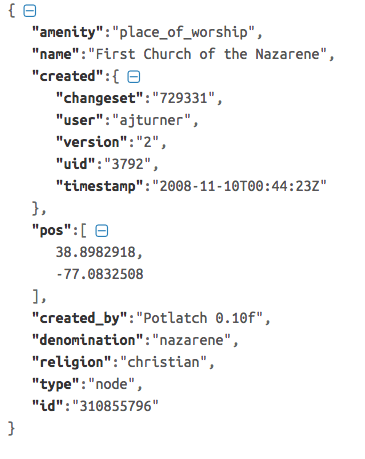

In [21]:
from IPython.display import Image
Image(filename='/Users/fengxinlin/Downloads/jupyter_pic.png')

In [22]:
import re
import codecs
import json
from datetime import datetime

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def shape_element(e):
    node = {} 
    address = {}
    node['created'] = {}
    node['pos'] = [0,0]
    if e.tag == "way":
        node['node_refs'] = []
    if e.tag == "node" or e.tag == "way" :
        node['type'] = e.tag
        #attributes
        for k, v in e.attrib.iteritems():
            #latitude
            if k == 'lat':
                try:
                    lat = float(v)
                    node['pos'][0] = lat
                except ValueError:
                    pass
            #longitude
            elif k == 'lon':
                try:
                    lon = float(v)
                    node['pos'][1] = lon
                except ValueError:
                    pass
            #creation metadata
            elif k in CREATED:
                node['created'][k] = v
            else:
                node[k] = v
        #children
        for tag in e.iter('tag'):
            k = tag.attrib['k']
            v = tag.attrib['v']
            if problemchars.match(k):
                continue
            elif lower_colon.match(k):
                k_split = k.split(':')
                #address fields
                if k_split[0] == 'addr':
                    k_item = k_split[1]
                    #streets
                    if k_item == 'street':
                        v = update_name(v, mapping, street_re)                    
                    #postal codes
                    if k_item == 'postcode':
                        v = update_zipcode(v)
                    address[k_item] = v
                    continue
            else:                
                #phone numbers
                if(is_phone_number(tag)):
                    v = update_phone(v)
            node[k] = v
 
        if address:
            node['address'] = address                          
                      
        #way children
        if e.tag == "way":
            for n in e.iter('nd'):
                ref = n.attrib['ref']
                node['node_refs'].append(ref);
        return node
    else:
        return None
                                                                                                                                            

In [23]:
from bson import json_util

def process_map(file_in, pretty = False):  
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

process_map(DC_OSM)  


[{'created': {'changeset': '7692025',
   'timestamp': '2011-03-27T22:40:38Z',
   'uid': '735',
   'user': 'blackadder',
   'version': '2'},
  'id': '234661',
  'pos': [38.8400891, -77.0506331],
  'type': 'node'},
 {'created': {'changeset': '7692025',
   'timestamp': '2011-03-27T22:40:45Z',
   'uid': '735',
   'user': 'blackadder',
   'version': '2'},
  'id': '234662',
  'pos': [38.8379624, -77.0503687],
  'type': 'node'},
 {'created': {'changeset': '7692025',
   'timestamp': '2011-03-27T22:40:44Z',
   'uid': '735',
   'user': 'blackadder',
   'version': '2'},
  'id': '234663',
  'pos': [38.8375383, -77.0500305],
  'type': 'node'},
 {'created': {'changeset': '7692025',
   'timestamp': '2011-03-27T22:40:44Z',
   'uid': '735',
   'user': 'blackadder',
   'version': '2'},
  'id': '234664',
  'pos': [38.8369362, -77.0499534],
  'type': 'node'},
 {'created': {'changeset': '7692025',
   'timestamp': '2011-03-27T22:40:42Z',
   'uid': '735',
   'user': 'blackadder',
   'version': '2'},
  'id': 

## 3.2 Data Overview
Make some "look at" to the data I just processed.

In [24]:
import signal
import subprocess
from pymongo import MongoClient

In [25]:
pro = subprocess.Popen('mongod', preexec_fn = os.setsid)
db_name = 'streetmap'

client = MongoClient('localhost:27017')
db = client[db_name]

In [26]:
#mongoimport command 
collection = DC_OSM[:DC_OSM.find('.')]
json_file = DC_OSM + '.json'

mongoimport = 'mongoimport -h 127.0.0.1:27017 ' + \
                  '--db ' + db_name + \
                  ' --collection ' + collection + \
                  ' --file ' + json_file

if collection in db.collection_names():
    print 'Dropping collection: ' + collection
    db[collection].drop() 
# Execute the command
print 'Executing: ' + mongoimport
subprocess.call(mongoimport.split())

Dropping collection: /Users/fengxinlin/Downloads/DC
Executing: mongoimport -h 127.0.0.1:27017 --db streetmap --collection /Users/fengxinlin/Downloads/DC --file /Users/fengxinlin/Downloads/DC.osm.json


0

After importing, get the collection from the database.

In [27]:
dc = db[collection]

Look at the size of the new JSON file, comparing to old downloaded one:

In [28]:
print "The DC.osm file size is {} mb.".format(os.path.getsize(DC_OSM) / 1.0e6)
print "The transformed JSON file size is {} mb.".format(os.path.getsize(DC_OSM + ".json") / 1.0e6)

The DC.osm file size is 332.767148 mb.
The transformed JSON file size is 371.459338 mb.


Number of Documents:

In [29]:
dc.find().count()

1584162

Number of unique users:

In [30]:
len(dc.distinct('created.user'))

1404

Number of Nodes and Ways:

In [31]:
print "Number of nodes:",dc.find({'type':'node'}).count()
print "Number of ways:",dc.find({'type':'way'}).count()


Number of nodes: 1411526
Number of ways: 172587


Name of top 10 contributors:

In [32]:
result = dc.aggregate([{"$group" : {"_id" : "$created.user", "count" : {"$sum" : 1}}}, 
                               {"$sort" : {"count" : - 1}}, {"$limit" : 10}])
for r in list(result):
    print(r)

{u'count': 565949, u'_id': u'aude'}
{u'count': 329856, u'_id': u'DavidYJackson_import'}
{u'count': 117681, u'_id': u'wonderchook'}
{u'count': 59130, u'_id': u'emacsen'}
{u'count': 54137, u'_id': u'RoadGeek_MD99'}
{u'count': 37278, u'_id': u'sejohnson'}
{u'count': 36713, u'_id': u'woodpeck_fixbot'}
{u'count': 27250, u'_id': u'Will White'}
{u'count': 26902, u'_id': u'kriscarle'}
{u'count': 22287, u'_id': u'scottasuchyta'}


The top 5 Most Referenced Nodes:

In [33]:
top_5 = dc.aggregate([{'$unwind': '$node_refs'}, {'$group': {'_id': '$node_refs', 'count': {'$sum': 1}}}, 
                              {'$sort': {'count': -1}}, {'$limit': 5}])
pprint.pprint(top_5)  
print

for node in top_5:  
    pprint.pprint(dc.find({'id': node['_id']})[0])


{u'_id': ObjectId('581b81dbbaa0a88196753b35'),
 u'created': {u'changeset': u'43221002',
              u'timestamp': u'2016-10-27T15:59:26Z',
              u'uid': u'3119079',
              u'user': u'cammace',
              u'version': u'7'},
 u'id': u'528551595',
 u'pos': [38.8975979, -77.036253],
 u'type': u'node'}
{u'_id': ObjectId('581b81f1baa0a88196897ec0'),
 u'created': {u'changeset': u'43221002',
              u'timestamp': u'2016-10-27T15:59:25Z',
              u'uid': u'3119079',
              u'user': u'cammace',
              u'version': u'2'},
 u'id': u'4460667662',
 u'pos': [38.8975571, -77.0363987],
 u'type': u'node'}
{u'_id': ObjectId('581b81f1baa0a88196897efb'),
 u'created': {u'changeset': u'43221002',
              u'timestamp': u'2016-10-27T15:59:25Z',
              u'uid': u'3119079',
              u'user': u'cammace',
              u'version': u'2'},
 u'id': u'4460667723',
 u'pos': [38.8976492, -77.0362529],
 u'type': u'node'}
{u'_id': ObjectId('581b81f1baa0a881968

Number of Documents with Street Addresses:

In [34]:
dc.find({'address.street' : {'$exists' : 1}}).count()

112565

Number of Documents with post code:

In [35]:
dc.find({'address.postcode' : {'$exists' : 1}}).count()

54671

In [ ]:
Number of phone with post code:

In [36]:
dc.find({'phone' : {'$exists' : 1}}).count()

732

# 4. More data query with MongoDB

List of top 10 cuisine in DC:

In [213]:
top_10 = dc.aggregate([{"$match":{"amenity":{"$exists":1},"amenity":"restaurant",}},      
                      {"$group":{"_id":{"Food":"$cuisine"},"count":{"$sum":1}}},
                      {"$project" : {"_id":0,"Food":"$_id.Food","Count":"$count"}},
                      {"$sort" : {"Count":-1}}, 
                      {"$limit": 10}])
for t in list(top_10):
    print(t)

{u'Food': None, u'Count': 582}
{u'Food': u'american', u'Count': 54}
{u'Food': u'thai', u'Count': 44}
{u'Food': u'pizza', u'Count': 44}
{u'Food': u'mexican', u'Count': 35}
{u'Food': u'italian', u'Count': 35}
{u'Food': u'chinese', u'Count': 27}
{u'Food': u'indian', u'Count': 24}
{u'Food': u'sandwich', u'Count': 19}
{u'Food': u'french', u'Count': 15}


List of top 15 amenities in DC:

In [214]:
top_10 = dc.aggregate([{'$match': {'amenity': {'$exists': 1}}}, 
                      {'$group': {'_id': '$amenity', 'count': {'$sum': 1}}}, 
                      {'$sort': {'count': -1}}, 
                      {'$limit': 15}])

for t in list(top_10):
    print(t)

{u'count': 5277, u'_id': u'parking'}
{u'count': 1095, u'_id': u'restaurant'}
{u'count': 627, u'_id': u'place_of_worship'}
{u'count': 520, u'_id': u'school'}
{u'count': 417, u'_id': u'fast_food'}
{u'count': 386, u'_id': u'cafe'}
{u'count': 295, u'_id': u'bench'}
{u'count': 282, u'_id': u'bank'}
{u'count': 230, u'_id': u'bicycle_rental'}
{u'count': 202, u'_id': u'bicycle_parking'}
{u'count': 196, u'_id': u'drinking_water'}
{u'count': 166, u'_id': u'post_box'}
{u'count': 151, u'_id': u'embassy'}
{u'count': 147, u'_id': u'waste_basket'}
{u'count': 142, u'_id': u'bar'}


List of top 10 Banks:

In [220]:
bank = dc.aggregate([{'$match': {'amenity': 'bank'}}, 
                      {'$group': {'_id': '$name', 'count': {'$sum': 1}}}, 
                      {'$sort': {'count': -1}},
                      {'$limit': 10}])
for b in list(bank):
    print(b)

{u'count': 32, u'_id': u'Bank of America'}
{u'count': 29, u'_id': u'PNC Bank'}
{u'count': 26, u'_id': u'SunTrust Bank'}
{u'count': 22, u'_id': u'Wells Fargo'}
{u'count': 16, u'_id': u'Wachovia'}
{u'count': 16, u'_id': u'BB&T'}
{u'count': 15, u'_id': u'Citibank'}
{u'count': 12, u'_id': u'Chevy Chase Bank'}
{u'count': 9, u'_id': u'TD Bank'}
{u'count': 8, u'_id': u'Capital One Bank'}


List of top 10 restaurants:

In [222]:
restaurant = dc.aggregate([{'$match': {'amenity': 'restaurant'}}, 
                      {'$group': {'_id': '$name', 'count': {'$sum': 1}}}, 
                      {'$sort': {'count': -1}},
                      {'$limit': 10}])

for r in list(restaurant):
    print(r)

{u'count': 7, u'_id': None}
{u'count': 5, u'_id': u'Chipotle'}
{u'count': 4, u'_id': u'Potbelly'}
{u'count': 3, u'_id': u'Buffalo Wild Wings'}
{u'count': 3, u'_id': u'Vapiano'}
{u'count': 3, u'_id': u'Sweet Green'}
{u'count': 3, u'_id': u'Lebanese Taverna'}
{u'count': 3, u'_id': u'Pho 14'}
{u'count': 3, u'_id': u'Legal Sea Foods'}
{u'count': 3, u'_id': u'Sweetgreen'}


# 5. Conclusion
### Some understanding of improve data quality of OSM:
When audit data, it was very clear that although there are minor error caused by human input, the dataset is fairly well-cleaned. Considering there might be hundreds of contributors on this map, human errors in this project will be very common here. I believe that a srtuctured input form in needed so that everyone can input the same data format to reduce the chance of error or we can create a more robust script to clean the data regularly. 

### Potential cost of the implement srtuctured input form:
There're few potential issues could you see that may arise from the implementation of this solution. One of which is the amount of effort to engineer all these processes and the cost of creating, auditing & maintaining these initiatives could be so overwhelm and require a dedicated team responsible for all these projects. Furthermore some information maybe not that easy to acquire, so it is necessary to design a wise algorithm to make judgement about weather the input format is valid.

For example, input phone number: it can be format as countrycode + 3 digits + 3 digits + 4 digits form, in this way, all the phone number are in same form.


# 6. Reference
<a href="http://wiki.openstreetmap.org/wiki/OSM_XML" target="_blank">http://wiki.openstreetmap.org/wiki/OSM_XML</a>

<a href="https://docs.mongodb.org/manual/reference/program/mongoimport/"> MongoDB Importing XML to JSON Guide </a>

<a href="/t/problem-when-converting-xml-file-to-json-string/196739/3">Problem when converting xml file to JSON string</a>







